## Load and clean data 

In [19]:
from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data

df = get_raw_data()
df.head()

The data comes from the following sources:
70.28 % from halide perovskites,
0.0277 % from chalcogenides perovskites,
29.70 % from chalcogenide semiconductors


,reduced_formulas,descriptive_formulas,bandgap,source
0,CH6I3NPb,MAPbI3,1.6,pvk
2,CH6I3NPb,MAPbI3,1.5,pvk
3,CH6I3NPb,MAPbI3,1.6,pvk
4,CH6I3NPb,MAPbI3,1.6,pvk
5,CH6I3NPb,MAPbI3,1.6,pvk


### Group Repeated Formulas

The dataset contains many repeated formulas and corresponding bandgap values. To make sure each formula is unique, we will use the `groupby_formula` function from CrabNet to group entries by their formulas and use the mean values for their bandgap. We make a new final DataFrame for our model, call it **df_reduced_formula** and adjust colum names etc.

Let's rename columns and use the `gourpby_formula` function from CrabNet:

In [20]:
from crabnet.utils.data import groupby_formula  # type: ignore
from tf_chpvk_pv.modeling.CrabNet.utils import save_processed_data
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df.rename(columns={'bandgap': 'target'}, inplace=True)
df.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df, how='median')
df_grouped_formula.head()

save_processed_data(df_grouped_formula)

2025-12-22 18:27:07.894 | INFO     | tf_chpvk_pv.modeling.CrabNet.utils:save_processed_data:77 - Processed data saved to /home/dagar/TF-ChPVK-PV/data/interim/df_grouped_formula_complete_dataset.csv


Let's check the shape of the DataFrame we would like to use for our ML:

In [21]:
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

for formula in df_grouped_formula['formula']:
    df_grouped_formula.loc[df_grouped_formula['formula'] == formula, 'source'] = df.loc[df['formula'] == formula, 'source'].values[0]

sc_percent = (df_grouped_formula.source.value_counts() / df_grouped_formula.shape[0] * 100).to_dict()
sources = [sc_percent.get(sc) for sc in ['pvk', 'chalcogenides', 'chalc_semicon']]

txt = 'After cleaning and groupin the data, the sources percentages are:' \
      '\n{0:.2f} % from halide perovskites,' \
      '\n{1:.4f} % from chalcogenides perovskites,' \
      '\n{2:.2f} % from chalcogenide semiconductors'.format(*sources)
print(txt)
df_grouped_formula.drop(columns=['source'], inplace=True)

The shape of the DataFrame is:  (3061, 3)
After cleaning and groupin the data, the sources percentages are:
32.60 % from halide perovskites,
0.3594 % from chalcogenides perovskites,
67.04 % from chalcogenide semiconductors


### Pettifor features

Let's add the pettifor features based on the grouped_formula to improve the training process. This function already separates the data in 3, being 80% for training, 10% for validation and 10% for test. This separation is done taking into account the source imbalance by stratifyng based on this feature.

In [22]:
from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df)

### Check Element Prevalence 

We will use `pymatviz` ([link to docs](https://pymatviz.janosh.dev/)) for visualizing the element prevalence.

<Axes: >

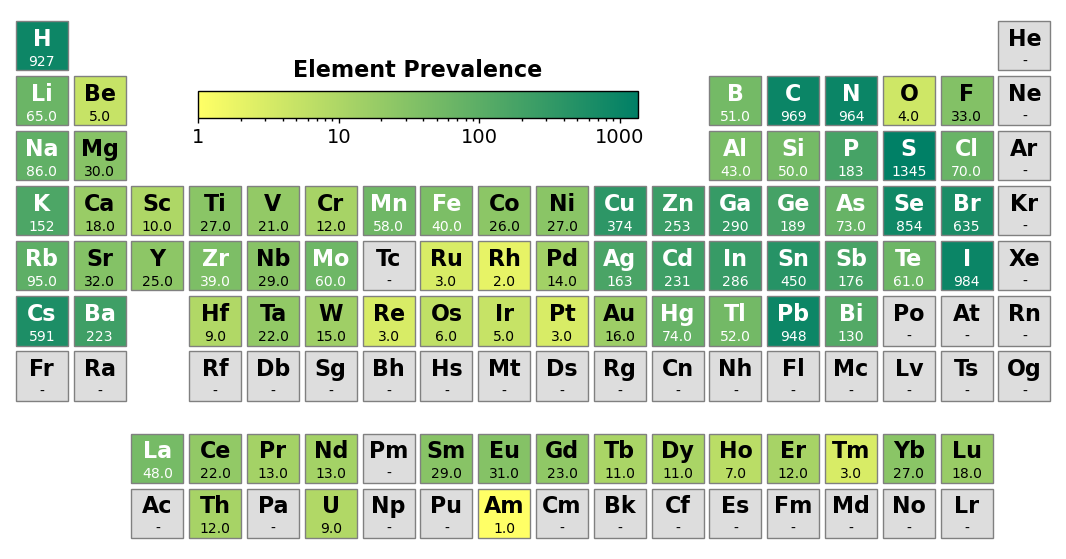

In [23]:
from pymatviz import count_elements, ptable_heatmap
import re

element_counts = count_elements([re.sub(r'\d+', '', x).replace('.', '') for x in df_grouped_formula['formula']])

# Plot the periodic table heatmap
ptable_heatmap(element_counts, log=True, cbar_title='Element Prevalence')

Let's continue and build the model in the next section!

## Build and Fit the Model 

We then fit the model using the CrabNet implementation.


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2448/2448 [00:00<00:00, 106339.97formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 306/306 [00:00<00:00, 75590.85formulae/s]


loading data with up to 8 elements in the formula
stepping every 200 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.493 val mae: 0.469


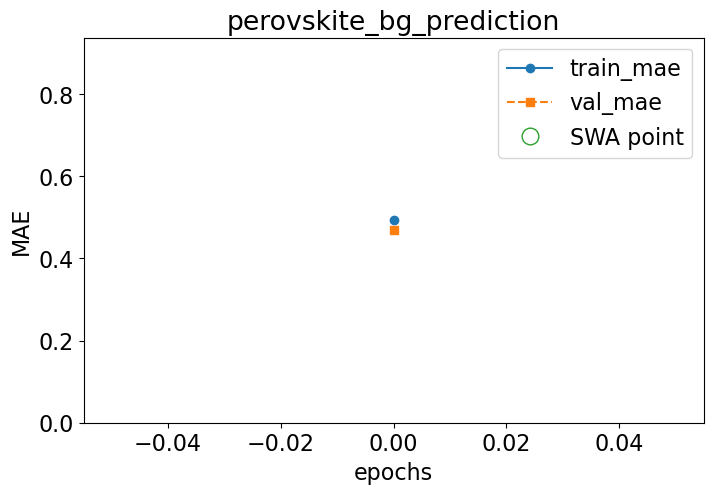

Epoch: 19/300 --- train mae: 0.235 val mae: 0.291


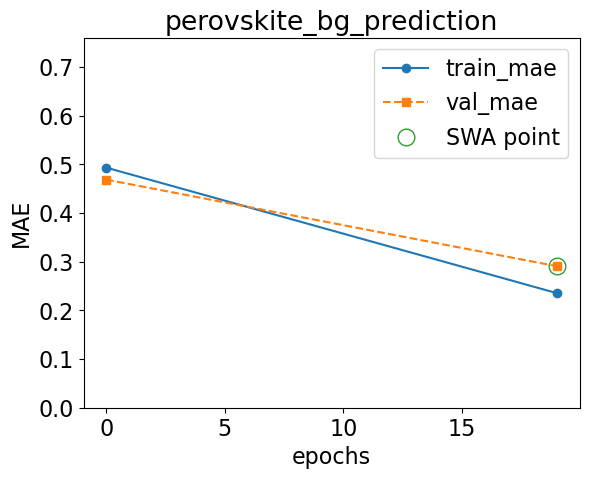

Epoch: 39/300 --- train mae: 0.153 val mae: 0.257


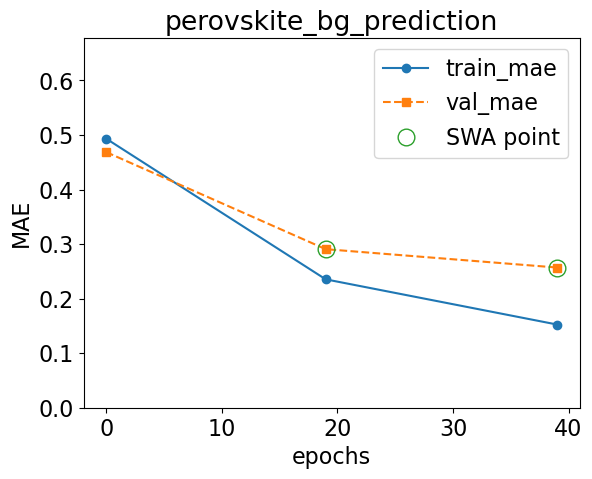

Epoch: 59/300 --- train mae: 0.0994 val mae: 0.248


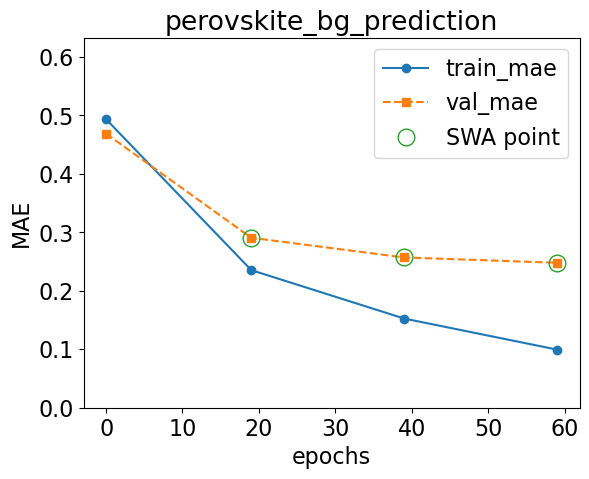

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0738 val mae: 0.252


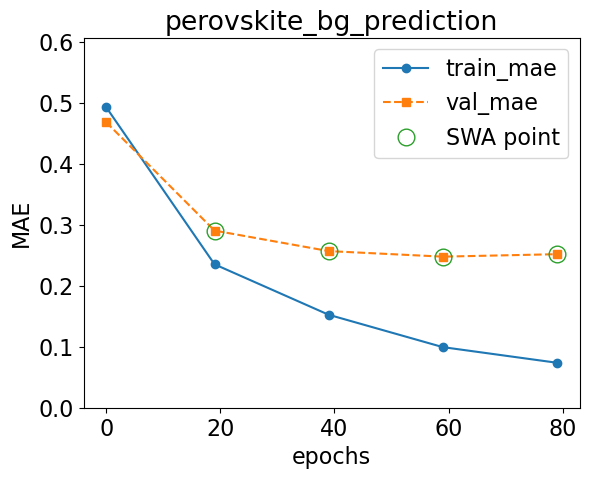

Epoch: 99/300 --- train mae: 0.0553 val mae: 0.25


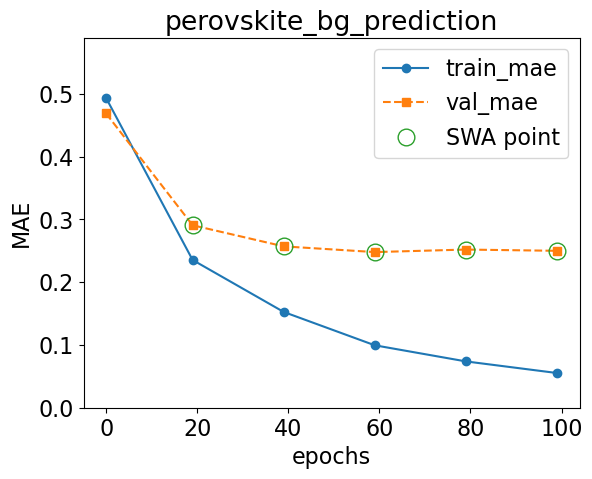

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 0.046 val mae: 0.255


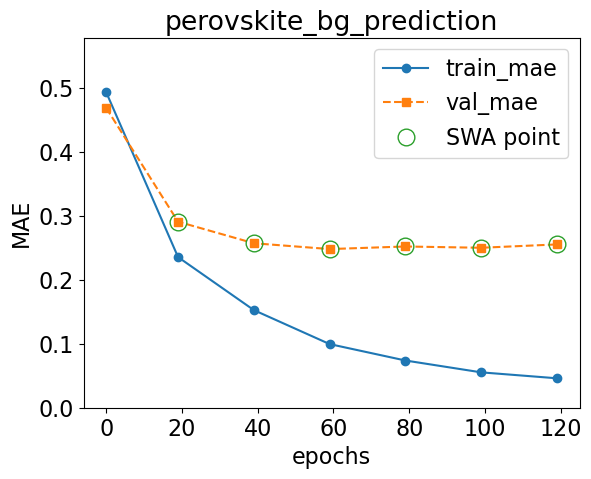

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 0.0395 val mae: 0.255


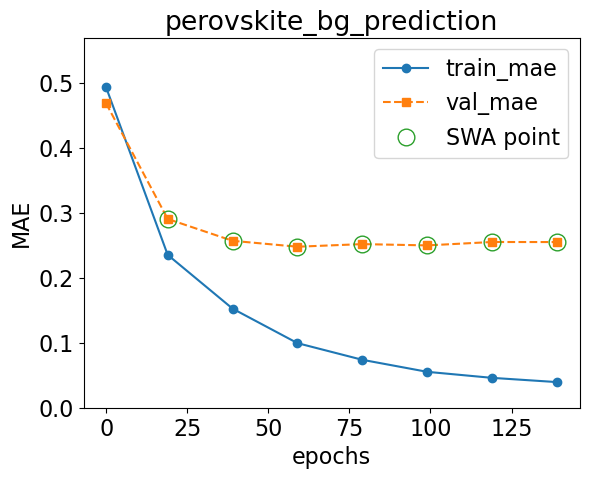

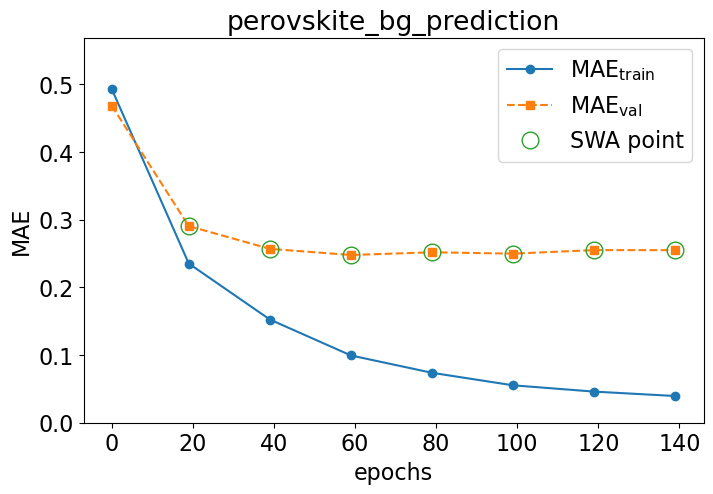

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_prediction) to models/trained_models/perovskite_bg_prediction.pth


In [6]:
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_prediction', elem_prop='mat2vec', learningcurve=True,
                          extend_features=feature_names)
crabnet_bandgap.fit(train_df, val_df)

## Model evaluation

After training, we evaluate the model using the validation data.


Results for source: pvk with data size 798

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 8 elements in the formula


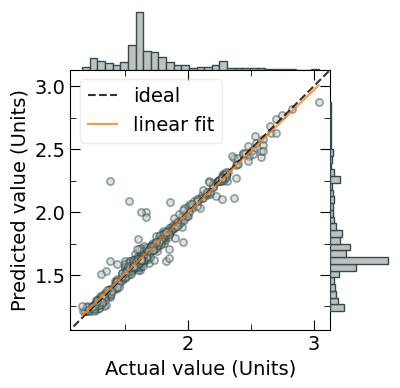

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

R2 score: 0.9643332278600774
MSE: 0.0030967452036173
MAE: 0.023694141305775417 eV

Results for source: chalcogenides with data size 9

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 9/9 [00:00<00:00, 56679.78formulae/s]

loading data with up to 4 elements in the formula


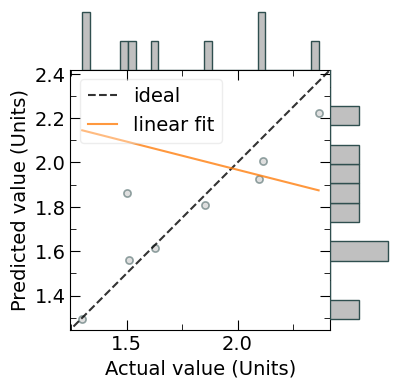

R2 score: -5.333639791673165
MSE: 0.8306138524818194
MAE: 0.3994617117775811 eV

Results for source: chalc_semicon with data size 1641

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 6 elements in the formula


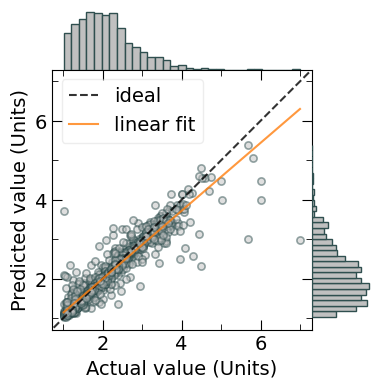

R2 score: 0.8902104699966332
MSE: 0.060679711710561114
MAE: 0.10587573769352628 eV


In [7]:
from tf_chpvk_pv.modeling.CrabNet.utils import get_test_r2_score_by_source_data

# Train data
get_test_r2_score_by_source_data(train_df, df, feature_names)

for validation data we have:

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Results for source: pvk with data size 100

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 100/100 [00:00<00:00, 78412.86formulae/s]


loading data with up to 8 elements in the formula


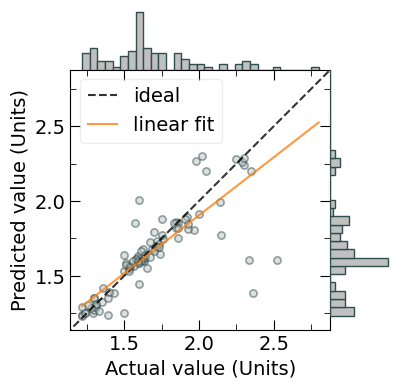

R2 score: 0.6604808557759447
MSE: 0.032586885289203546
MAE: 0.08356945177307519 eV

Results for source: chalcogenides with data size 1

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 4 elements in the formula


/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/modeling/CrabNet/utils.py:206: RankWarning: Polyfit may be poorly conditioned
  act_pred(df['target'], df_predicted)


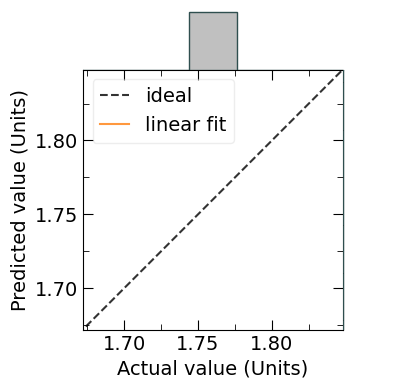

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://

R2 score: nan
MSE: 0.06710345482263004
MAE: 0.259043345451355 eV

Results for source: chalc_semicon with data size 205

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 205/205 [00:00<00:00, 175404.39formulae/s]


loading data with up to 6 elements in the formula


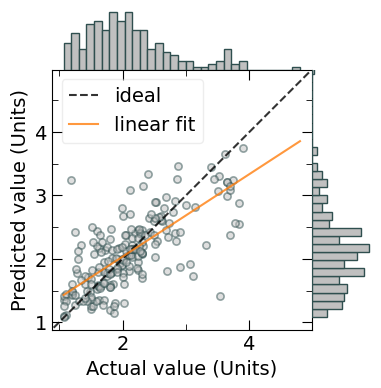

R2 score: 0.5326157823666502
MSE: 0.22424596587748244
MAE: 0.3256107189550632 eV


In [8]:
# Validation data
get_test_r2_score_by_source_data(val_df, df, feature_names)

and finally for test data:


Results for source: pvk with data size 100

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 8 elements in the formula


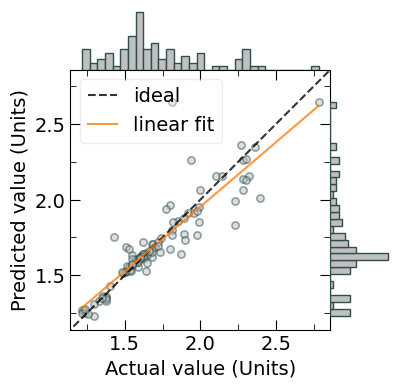

R2 score: 0.8107793990202605
MSE: 0.01793601741430889
MAE: 0.07136847625267617 eV

Results for source: chalcogenides with data size 1

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 3 elements in the formula


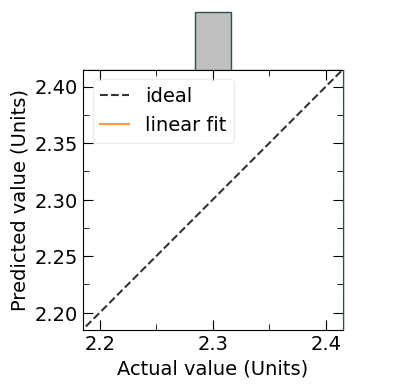

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://

R2 score: nan
MSE: 0.08297183180211722
MAE: 0.2880483150482176 eV

Results for source: chalc_semicon with data size 206

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 206/206 [00:00<00:00, 264714.04formulae/s]


loading data with up to 6 elements in the formula


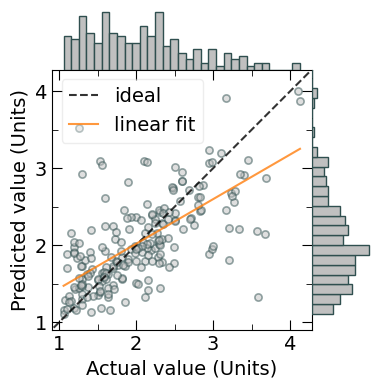

R2 score: 0.3527638369112569
MSE: 0.29168998944890095
MAE: 0.3729005486988327 eV


In [9]:
# Test data
get_test_r2_score_by_source_data(test_df, df, feature_names)

Now the error asociated with the complete test data set...


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 8 elements in the formula


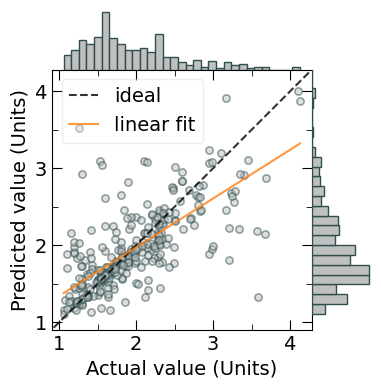

R2 score: 0.43812203223217416
MSE: 0.20183944737687923
MAE: 0.27440523357426344 eV


In [10]:
from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
# Test data
test_r2_score(test_df, feature_names)

## Predict Bandgap from New Formulas

Now we are ready to run some predictions using our trainned model. 

In [11]:
#CrystaLLM data predictions
from tf_chpvk_pv.modeling.CrabNet.utils import get_CrystaLLM_predictions, get_SISSO_predictions, get_experimental_predictions

df_CrystaLLM = get_CrystaLLM_predictions()

#SISSO data predictions

df_SISSO = get_SISSO_predictions()

#Experimentally reported data predictions

df_experimental = get_experimental_predictions()



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4987.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9341.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9383.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4882.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1921.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8289.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9300.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7543.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6241.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4583.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4969.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8630.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3609.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8050.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4148.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4211.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6523.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3271.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8035.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8004.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 788.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4410.41formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2423.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4744.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8630.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8192.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1911.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4524.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9020.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4100.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7973.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4888.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7810.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4495.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6808.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4554.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4382.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8701.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1890.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4013.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3788.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3123.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7157.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9362.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7639.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3708.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7854.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3429.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7724.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4112.06formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6269.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8886.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3061.54formulae/s]


loading data with up to 3 elements in the formula


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4946.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11491.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5053.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7002.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3334.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6462.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6034.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3134.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5890.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5991.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7061.12formulae/s]

loading data with up to 3 elements in the formula



Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5029.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3028.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7169.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6831.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7133.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 554.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2335.36formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5841.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6326.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5966.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3177.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5809.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6700.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 349.41formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4328.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2652.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3826.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7096.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3905.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4185.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3563.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4510.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6955.73formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8490.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4048.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5077.85formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5370.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7557.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4211.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8035.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3446.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4505.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9776.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2976.79formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7256.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3095.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9058.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8559.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4987.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2766.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9177.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4723.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4108.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8867.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8630.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2531.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2495.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4068.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4319.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4848.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4036.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3326.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7013.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6700.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3061.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6689.48formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5940.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6355.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3498.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7839.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5210.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1010.68formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4148.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6114.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7345.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4096.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5108.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4744.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8648.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8081.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5518.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7423.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 364.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2755.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5793.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2310.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8981.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7898.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7436.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3628.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2600.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7049.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4485.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 416.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3847.99formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5489.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3435.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3460.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3226.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9177.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5907.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4755.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6364.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5793.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1271.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3199.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7319.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8388.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4462.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4169.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7557.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3862.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7869.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8962.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9279.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4433.73formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4975.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7049.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5482.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2511.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9198.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3603.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7989.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4629.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6177.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2863.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1979.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3443.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7133.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5229.81formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5793.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6316.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3052.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6335.81formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5607.36formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2700.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5005.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4940.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3339.41formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4981.36formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7898.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6000.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4696.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7133.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9177.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7345.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3518.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6754.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2493.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4804.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3407.23formulae/s]

loading data with up to 3 elements in the formula



Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5841.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6775.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8962.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4249.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4419.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4017.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2289.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8176.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4266.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3682.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4359.98formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4275.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4310.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11428.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4788.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4373.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9020.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4798.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4279.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4084.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3474.98formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4771.68formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8701.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3728.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7358.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8176.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4554.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3869.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8507.72formulae/s]


loading data with up to 3 elements in the formula


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7410.43formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for BaZrS3: 1.75 eV
Bandgap prediction for BaZrS3: 1.81 ± 0.14 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8160.12formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for BaTiS3: 1.3 eV
Bandgap prediction for BaTiS3: 4.0 ± 4.28 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5468.45formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for LaYS3: 2.3 eV
Bandgap prediction for LaYS3: 2.01 ± 0.09 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6043.67formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for CaZrS3: 1.5 eV
Bandgap prediction for CaZrS3: 1.86 ± 0.12 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4957.81formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for BaZrSe3: 1.3 eV
Bandgap prediction for BaZrSe3: 1.29 ± 0.07 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7194.35formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for BaHfS3: 2.17 eV
Bandgap prediction for BaHfS3: 2.01 ± 0.19 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8793.09formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for SrZrS3: 2.05 eV
Bandgap prediction for SrZrS3: 1.93 ± 0.16 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10485.76formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped t

loading data with up to 3 elements in the formula
Experimental bandgap for SrHfS3: 2.32 eV
Bandgap prediction for SrHfS3: 2.22 ± 0.18 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7281.78formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 4 elements in the formula
Experimental bandgap for BaZr(S0.6Se0.4)3: 1.76 eV
Bandgap prediction for BaZr(S0.6Se0.4)3: 1.5 ± 0.08 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9868.95formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 4 elements in the formula
Experimental bandgap for Ba(Zr0.95Ti0.05)S3: 1.63 eV
Bandgap prediction for Ba(Zr0.95Ti0.05)S3: 1.62 ± 0.06 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6615.62formulae/s]

loading data with up to 4 elements in the formula
Experimental bandgap for Ba(Zr0.96Ti0.04)S3: 1.51 eV
Bandgap prediction for Ba(Zr0.96Ti0.04)S3: 1.56 ± 0.04 eV


# Training without Chalcogenide perovskites

The shape of the DataFrame is:  (3050, 3)
After cleaning and groupin the data, the sources percentages are:
32.72 % from halide perovskites,
67.28 % from chalcogenide semiconductors

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2440/2440 [00:00<00:00, 122681.63formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 305/305 [00:00<00:00, 126647.14formulae/s]

loading data with up to 8 elements in the formula
stepping every 200 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.494 val mae: 0.487


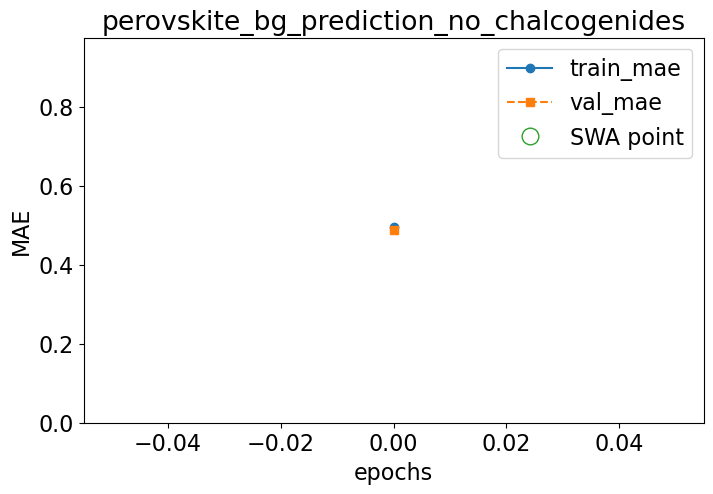

Epoch: 19/300 --- train mae: 0.248 val mae: 0.272


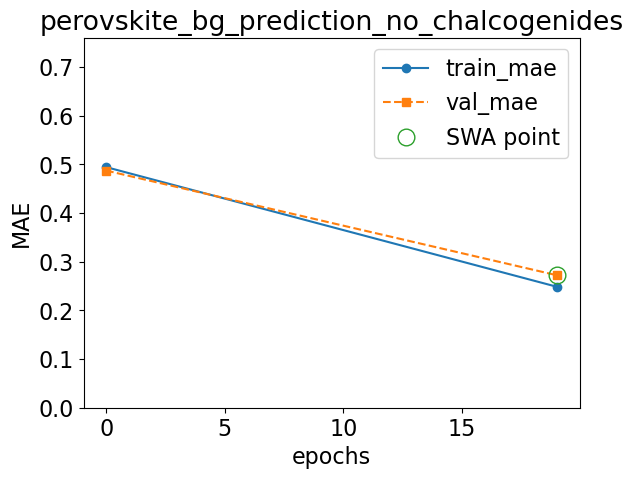

Epoch: 39/300 --- train mae: 0.167 val mae: 0.252


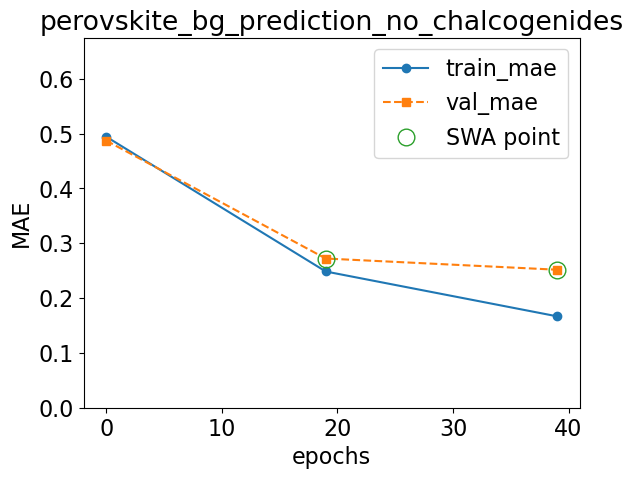

Epoch: 59/300 --- train mae: 0.115 val mae: 0.245


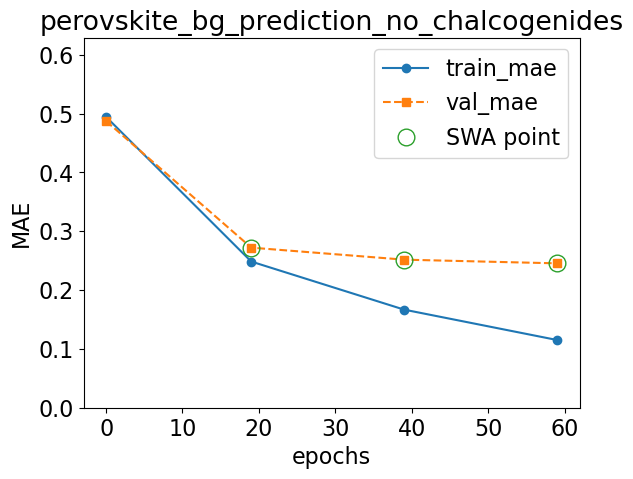

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0859 val mae: 0.256


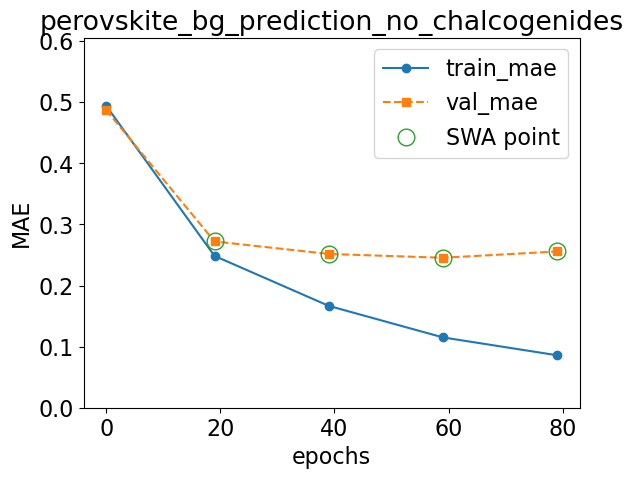

Epoch 99 failed to improve.
Discarded: 2/3 weight updates
Epoch: 99/300 --- train mae: 0.0682 val mae: 0.258


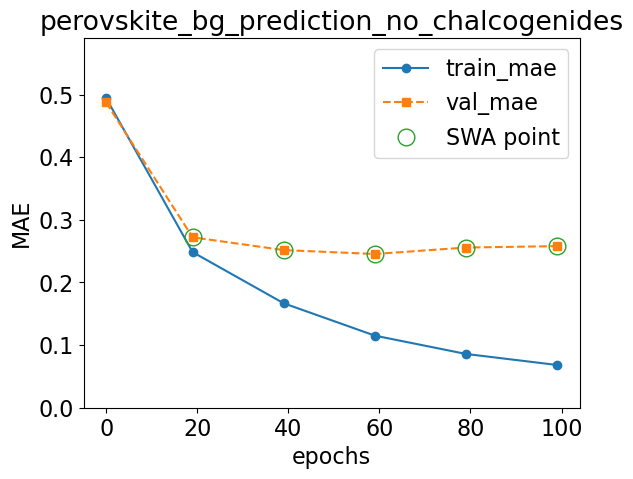

Epoch 119 failed to improve.
Discarded: 3/3 weight updates
Epoch: 119/300 --- train mae: 0.0565 val mae: 0.258


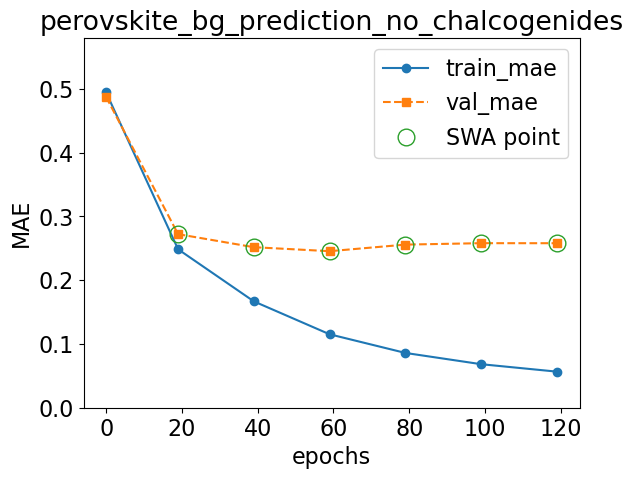

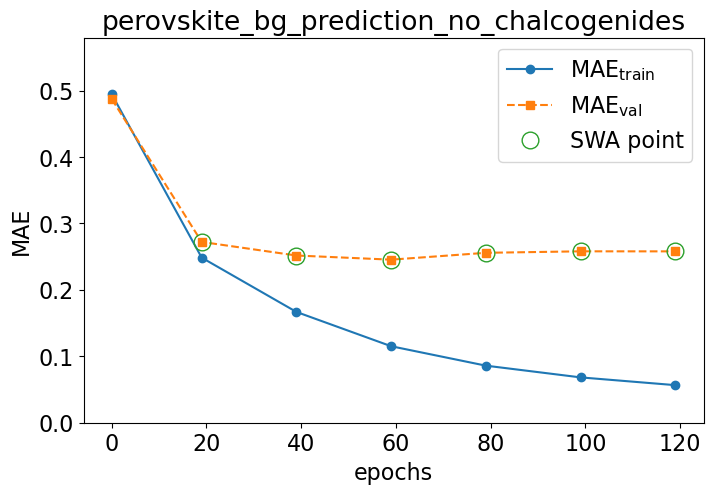

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_prediction_no_chalcogenides) to models/trained_models/perovskite_bg_prediction_no_chalcogenides.pth


In [10]:
df_no_chalcogenides = df[df['source'] != 'chalcogenides'].copy()

from crabnet.utils.data import groupby_formula  # type: ignore
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_no_chalcogenides.rename(columns={'bandgap': 'target'}, inplace=True)
df_no_chalcogenides.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_no_chalcogenides, how='median')

print('The shape of the DataFrame is: ', df_grouped_formula.shape)

for formula in df_grouped_formula['formula']:
    df_grouped_formula.loc[df_grouped_formula['formula'] == formula, 'source'] = df_no_chalcogenides.loc[df_no_chalcogenides['formula'] == formula, 'source'].values[0]

sc_percent = (df_grouped_formula.source.value_counts() / df_grouped_formula.shape[0] * 100).to_dict()
sources = [sc_percent.get(sc) for sc in ['pvk', 'chalc_semicon']]

txt = 'After cleaning and groupin the data, the sources percentages are:' \
      '\n{0:.2f} % from halide perovskites,' \
      '\n{1:.2f} % from chalcogenide semiconductors'.format(*sources)
print(txt)
df_grouped_formula.drop(columns=['source'], inplace=True)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df)

from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_prediction_no_chalcogenides', elem_prop='mat2vec', learningcurve=True,
                          extend_features=feature_names)
crabnet_bandgap.fit(train_df, val_df)

Comparision of predicted and actual values for the chalcogenide perovskite data set, when they are <b>NOT</b> included in the training dataset

The shape of the DataFrame is:  (11, 3)


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 11/11 [00:00<00:00, 54729.95formulae/s]


loading data with up to 4 elements in the formula


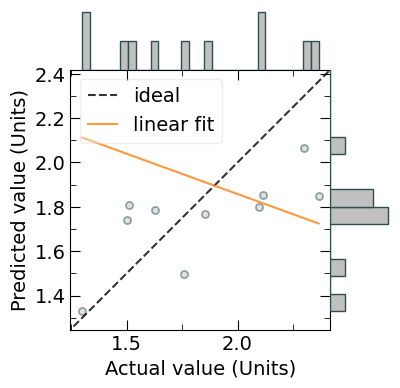

R2 score: -3.640519219564185
MSE: 0.6170433208877033
MAE: 0.44071960449218756 eV


In [11]:
df_chalcogenides = df[df['source'] == 'chalcogenides'].copy()

# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_chalcogenides.rename(columns={'bandgap': 'target'}, inplace=True)
df_chalcogenides.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_chalcogenides, how='median')

print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

df_test_chalcogenides = get_petiffor_features(df_grouped_formula, original_df=df, train=False)

from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS


# Perovskite chalcogenide test data
test_r2_score(df_test_chalcogenides, feature_names,
              model_path = TRAINED_MODELS / 'perovskite_bg_prediction_no_chalcogenides.pth')

Comparision of predicted and actual values for the chalcogenide perovskite data set, when they <b>are</b> included in the training dataset

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 11/11 [00:00<00:00, 55788.81formulae/s]


loading data with up to 4 elements in the formula


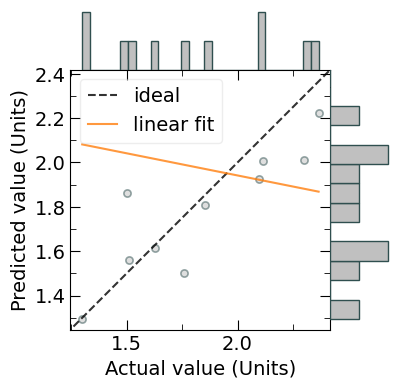

R2 score: -4.213534516854308
MSE: 0.6932363599055565
MAE: 0.3765679151361639 eV


In [12]:
# Perovskite chalcogenide test data
test_r2_score(df_test_chalcogenides, feature_names,
              model_path = TRAINED_MODELS / 'perovskite_bg_prediction.pth')

In [25]:
def mean_absolute_error(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Input lists must have the same length.")
    errors = [abs(t - p) for t, p in zip(y_true, y_pred)]
    return sum(errors) / len(errors)

MAE_null_ch = mean_absolute_error(df_test_chalcogenides['target'], df_test_chalcogenides['target'].median().repeat(df_test_chalcogenides.shape[0]))
MAE_null_df = mean_absolute_error(test_df['target'], test_df['target'].median().repeat(test_df.shape[0]))

print('Mean Absolute Error (MAE) null model (median) for test chalcogenide perovskites: {:.4f} eV'.format(MAE_null_ch))
print('Mean Absolute Error (MAE) null model (median) for the test dataset: {:.4f} eV'.format(MAE_null_df))

MAE_null_ch = mean_absolute_error(df_test_chalcogenides['target'], df_test_chalcogenides['target'].mean().repeat(df_test_chalcogenides.shape[0]))
MAE_null_df = mean_absolute_error(test_df['target'], test_df['target'].mean().repeat(test_df.shape[0]))

print('Mean Absolute Error (MAE) null model (mean) for test chalcogenide perovskites: {:.4f} eV'.format(MAE_null_ch))
print('Mean Absolute Error (MAE) null model (mean) for the test dataset: {:.4f} eV'.format(MAE_null_df))

Mean Absolute Error (MAE) null model (median) for test chalcogenide perovskites: 0.3173 eV
Mean Absolute Error (MAE) null model (median) for the test dataset: 0.4635 eV
Mean Absolute Error (MAE) null model (mean) for test chalcogenide perovskites: 0.3203 eV
Mean Absolute Error (MAE) null model (mean) for the test dataset: 0.4768 eV
